# Flowline mapping of a polymer sample

This tutorial demonstrates orientation mapping in a soft matter sample.  We use flowline visualizations to be able to see multiple orientations in the same probe position. This dataset contains substantial de-scan, and thus we will need to carefully calibrate the center position.

### Tutorial data

[dataset19_bin4.h5](https://drive.google.com/file/d/1lK-TAMXN1MpWG0Q3_4vss_uEZgW2_Xh7/view?usp=sharing) (890 MB)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Alex Rakowski (arakowski@lbl.gov)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)

Data collected by Yael Tsarfati (yaeltsa@stanford.edu).


In [1]:
import py4DSTEM
print(py4DSTEM.__version__)

0.14.2


In [2]:
dirpath = '/Users/Ben/work/data/py4dstem_sampledata/flowlines/'
# dirpath = '/media/cophus/DataSSD1/4DSTEM/tutorials/'
filepath_data =  dirpath + 'dataset19_bin4.h5'
filepath_analysis =  dirpath + '_analysis_'

# Load data

In [3]:
py4DSTEM.print_h5_tree(filepath_data)

/
|---4DSTEM_experiment
    |---data
    |   |---coordinates
    |   |---counted_datacubes
    |   |---datacubes
    |   |   |---datacube_0
    |   |---diffractionslices
    |   |---pointlistarrays
    |   |---pointlists
    |   |---realslices
    |---metadata
        |---calibration
        |---comments
        |---microscope
        |---sample
        |---user




In [4]:
# This is an older version py4DSTEM file - we will use the old syntax to read the file:
dataset = py4DSTEM.read(
    filepath_data,
    data_id = 'datacube_0',
)

# Virtual imaging 

In [5]:
dataset.get_dp_max()
dataset.get_dp_mean();

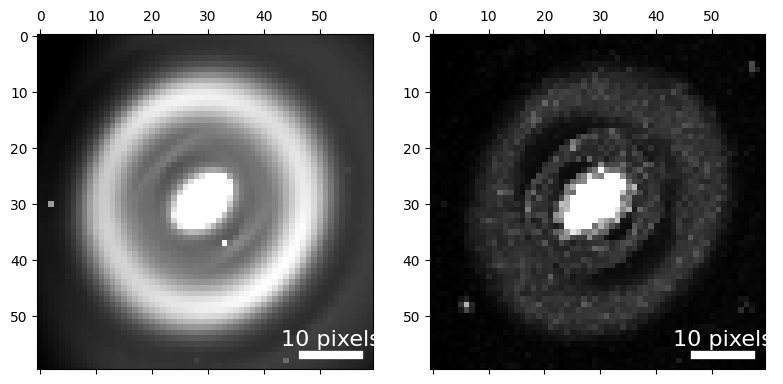

In [6]:
py4DSTEM.visualize.show(
    [
        dataset.tree('dp_mean'),
        dataset.tree('dp_max'),                 
    ],
    axsize = (4,4),
)

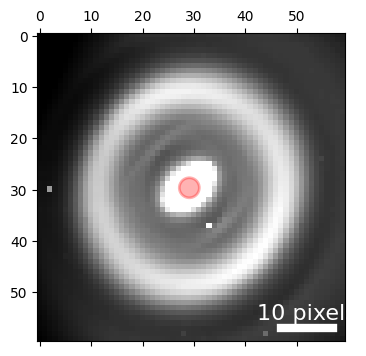

In [7]:
# Get approximate probe size (note this dataset has a lot of de-scan)

qr, qx, qy = dataset.get_probe_size()

py4DSTEM.visualize.show_circles(
    dataset.tree('dp_mean'), 
    (qx, qy), 
    qr, 
    figsize=(4,4),
)

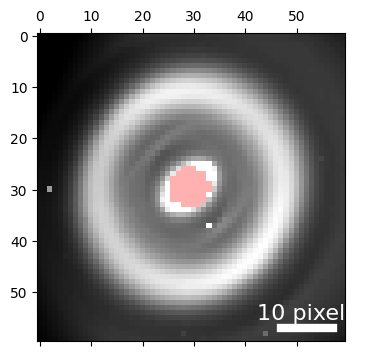

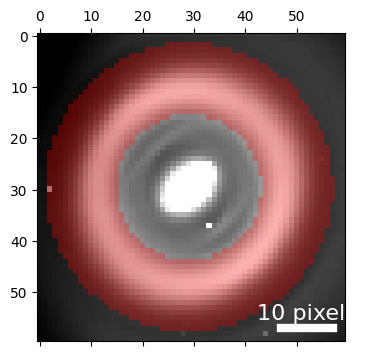

In [8]:
expand_BF = 2
det_DF_radii = (14,28)
center = (qx,qy)


# Show selected virtual detectors

dataset.position_detector(
    mode = 'circle',
    geometry = (
        center,
        qr+expand_BF
    ),
    figsize = (4,4)
)

dataset.position_detector(
    mode = 'annulus',
    geometry = (
        center,
        det_DF_radii,
    ),
    figsize = (4,4)
)

In [9]:
# Calculate both virtual images
dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center, qr + expand_BF),
    name = 'bright_field'
);
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center, det_DF),
    name = 'dark_field'
);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32400/32400 [00:00<00:00, 55509.20it/s]


NameError: name 'det_DF' is not defined

In [ ]:
# Show the BF and DF images
py4DSTEM.show(
    [
        dataset.tree('bright_field'), 
        dataset.tree('dark_field'), 
    ],
    axsize=(4,4),
    cmap='viridis'
)

# Calibrate - centering 

In [ ]:
# Find the brightest disk in the image, which will be the unscattered center beam in this data.
(qx0, qy0, _) = py4DSTEM.process.calibration.get_origin(
    dataset,
    r = 2.0,
    rscale = 2.0,
)

In [ ]:
# Fit a plane to the origins
(qx0_fit, qy0_fit, qx0_res, qy0_res) = py4DSTEM.process.calibration.fit_origin(
    (qx0, qy0),
)

# plot the original and fitted origin shifts
py4DSTEM.show(
    [
        qx0, qx0_fit,
        qy0, qy0_fit,
    ],
    cmap = 'RdBu_r',
)

In [ ]:
# add the centering calibration to the dataset
dataset.calibration.set_origin((qx0_fit, qy0_fit))

# Calibration - ellipticity

In [ ]:
# First, generate mean diffraction pattern using the centered patterns
dp_mean_centered = dataset.get_virtual_diffraction(
    method = 'mean',
    shift_center = True,
)

In [ ]:
# compare the original, unshifted mean DP to the corrected one:
py4DSTEM.show(
    [
        dataset.tree('dp_mean'),
        dp_mean_centered,
    ],
    axsize = (4,4),
    scaling = 'log',
    vmax = 1,
)

Now we can safely fit the ellipticity by fitting a radial Gaussian to the amorphous halo, or to the sharper inner ring.

In [ ]:
# Fitting range for diffraction ring
# q_range = (12,28)  # amorphous halo
q_range = (8,12)  # inner ring


# This is a test plot, showing you the fitting range
py4DSTEM.process.polar.fit_amorphous_ring(
    dp_mean_centered,
    radial_range = q_range, 
    show_fit_mask = True,
    verbose = False,
    figsize = (4,4),
);

In [ ]:
# Perform the fitting

params = py4DSTEM.process.polar.fit_amorphous_ring(
    dp_mean_centered,
    # center = center_guess,
    radial_range = q_range, 
    verbose = False,
    figsize = (4,4),
)

In [ ]:
# apply the elliptic calibrations
dataset.calibration.set_ellipse(params[2:5])

# Polar transformation

In [ ]:
polardata = py4DSTEM.PolarDatacube(
    dataset,
    qmin = 3.0,
    qmax = 30.0,
    qstep = 0.5,
    n_annular = 90,
    two_fold_symmetry = True,
    qscale = 1.0,
)

In [ ]:
# show polar transformation for different probe positions

x,y = 40,20
# x,y = 160,1
# x,y = 1,160

# Show pattern in cartesian + polar
py4DSTEM.show( 
    [
        dataset.data[x,y],
        polardata.data[x,y],
    ],
    # intensity_range = 'absolute',
    # vmax = 40,
    cmap = 'turbo',
    axsize = (4,4),
)

In [ ]:
# Testing peak detection hyperparameters

x,y = 40,20
# x,y = 40,40


# Hyperparameters
detect_params = {
    'sigma_annular_deg': 10.0,
    'sigma_radial_px': 1.0,
    'threshold_abs': 0.5,
    'threshold_prom_radial': 0.2,
    'threshold_prom_annular': 0.2,
}

peaks_polar, sig_bg, sig_bg_mask = polardata.find_peaks_single_pattern(
    x,y,
    plot_power_scale =  0.5,    
    **detect_params,
    return_background = True,
    figsize = (8,4),
)

In [ ]:
# initial peak detection for all probe positions
polardata.find_peaks(
    **detect_params,
)

# Global pattern refinement

Goal - for each image, refine a background model plus all peaks.

In [ ]:
polardata.model_radial_background(
    ring_position = 19.0,
    ring_sigma = 3.0,
    # refine_model = False,
    figsize = (8,3),
)

In [ ]:
# Note that this is commented out - the full refinement would take too long to use in a tutorial!

# Loop through all probe positions and refine full model:
#    background signal + sum of all peaks (elliptic gaussians)
# polardata.refine_peaks(
# )


In [ ]:
# # Save data
# py4DSTEM.io.save(
#     file_analysis + '_background_fits_01.h5',
#     polardata.background_refine, 
#     mode="o")

In [ ]:
# py4DSTEM.io.save(
#     file_analysis + '_peak_fits_01.h5',
#     polardata.peaks_refine, 
#     mode="+")

# Orientation maps - flowline visualization

In [ ]:
# This is a 1D histogram of the detected peaks, before refinement
polardata.plot_radial_peaks(
    # q_pixel_units = True,
    figsize = (8,2),
)

In [ ]:
orient_hist = polardata.make_orientation_histogram(
    [
        [8, 10],  
        [17, 20], 
    ],
    normalize_intensity_image = True,
    normalize_intensity_stack = False,
    use_refined_peaks = False,
)

In [ ]:
# Plot the total signals in each orientation matrix
py4DSTEM.show(
    [
        orient_hist[0].sum(axis=2),
        orient_hist[1].sum(axis=2),
    ],
    cmap='gray',
    axsize=(3,3),
    ticks = False,
)

In [ ]:
# Generate flowline arrays
orient_flowlines = py4DSTEM.process.diffraction.make_flowline_map(
    orient_hist,
    sep_xy = 4.0,
)

In [ ]:
# Draw flowline images for both sets of peaks, where each plane is colored by its orientation
im_flowline_0 = py4DSTEM.process.diffraction.make_flowline_rainbow_image(
    orient_flowlines[0][None,:,:,:],
    int_range=[0,0.05],
    greyscale=False,
    white_background=False,
    plot_images=True,
    sum_radial_bins=True,
    figsize = (4,4),
)
im_flowline_1 = py4DSTEM.process.diffraction.make_flowline_rainbow_image(
    orient_flowlines[1][None,:,:,:],
    int_range=[0,0.05],
    greyscale=False,
    white_background=False,
    plot_images=True,
    sum_radial_bins=True,
    figsize = (4,4),
)

In [ ]:
# Draw flowline images coloured by the radial ring the diffraction spots came from
im_flowline_02 = py4DSTEM.process.diffraction.make_flowline_combined_image(
    orient_flowlines,
    int_range=[0,0.1],
    cvals = [
        [1.0,0.0,0.0],
        [0.0,0.8,1.0],
        ],
    plot_images=True,
    white_background=True,
    sum_radial_bins=True,
    figsize = (4,4),
)